# Tutorial: Dynamical actions with $\texttt{galpy}$

... using the Staeckel Fudge (Binney 2012) implemented in $\texttt{galpy}$ (Bovy 2015).

* Binney 2012: http://adsabs.harvard.edu/abs/2012MNRAS.426.1324B
* Bovy 2015: http://adsabs.harvard.edu/abs/2015ApJS..216...29B ($\texttt{galpy}$ paper)
* Sanders & Binney 2016: http://adsabs.harvard.edu/abs/2016MNRAS.457.2107S (for a short and comprehensive description of the Staeckel Fudge)

This tutorial was put together for the Gaia Sprint in New York, 17.-21. October 2016, by Wilma Trick and Johanna Coronado from MPIA in Heidelberg.

### Table of Contents:

**A. Quick start: How to calculate actions in a default Milky Way potential**
1. Preparation
2. Load the default Milky Way potential from $\texttt{galpy}$
3. Understanding $\texttt{galpy}$ units
4. Rescale stellar 6D coordinates (in Galactocentric coordinates)
5. Setting up the Staeckel Fudge
6. Calculate the actions

**B. Appendix: Additional information**
1. Do I have to do the coordinate transformation to Galactocentric coordinates myself?
2. What is $\Delta$ and can we estimate it better?
3. What if I want to set my own favourite potential?
4. How does the orbit belonging to the actions I just calculated looks like?
5. My stellar 6D coordinates have measurement uncertainties - how can I translate them to action space?
6. I want to do other stuff - is it possible with $\texttt{galpy}$?
7. This is great - but what *are* actions?

# A. Quick start: How to calculate actions in a default Milky Way potential

### 1. Preparation:

Install $\texttt{galpy}$. For example:
1. git clone https://github.com/jobovy/galpy/ 
2. python setup.py install --prefix=~/local 

More details in the $\texttt{galpy}$ documentation: http://galpy.readthedocs.io/en/latest/installation.html

In [17]:
%matplotlib inline

### 2. Load the default Milky Way potential from $\texttt{galpy}$:

$\texttt{galpy}$ has a simple axisymmetric Milky Way potential implemented, with Miyamoto-Nagai disk, NFW halo and power-law bulge with cut-off, fitted to several observational constraints. (See $\texttt{galpy}$ paper for details.)

In [18]:
from galpy.potential import MWPotential2014 as pot

### 3. Understanding $\texttt{galpy}$ units:

$\texttt{galpy}$ works in a unit framework where the model galaxy is scaled such that $v_\text{circ}(R=1)=1$. For the MWPotential2014, for example, all lengths and velocities are therefore given in units of:

In [19]:
#galpy scale units:
_REFR0 = 8.   #[kpc]  --> galpy length unit
_REFV0 = 220. #[km/s] --> galpy velocity unit

See also documentation: http://galpy.readthedocs.io/en/latest/getting_started.html#updated-in-v1-2-units-in-galpy

### 4. Rescale stellar 6D coordinates (in Galactocentric coordinates):

You need the current poistion and velocity coordinates of your star in Galactocentric coordinates and rescale them to $\texttt{galpy}$ units:

In [20]:
import numpy as np
R   = np.array([8.,8.1])    / _REFR0 #Galactocentric radius
vR  = np.array([20.,0.])    / _REFV0 #radial velocity
phi = np.array([0.,0.])              #Galactocentric azimuth angle (not needed for actions in axisymmetric potential)
vT  = np.array([220.,230.]) / _REFV0 #tangential velocity
z   = np.array([0.5,0.1])    / _REFR0 #height above plane
vz  = np.array([20.,0.])    / _REFV0 #vertical velocity

### 5. Setting up the Staeckel Fudge:

The Staeckel Fudge requires us to set the parameter $\Delta$ (the focal length of the closest Staeckel potential's confocal coordinate system). But as a first try we can just use $\Delta=0.45$.

In [21]:
from galpy.actionAngle import actionAngleStaeckel

aAS = actionAngleStaeckel(
        pot   = pot,        #potential
        delta = 0.45,       #focal length of confocal coordinate system
        c     = True        #use C code (for speed)
        )

### 6. Calculate the actions:

In [41]:
jR,lz,jz = aAS(R,vR,vT,z,vz)
print "Radial   action  J_R = ", jR*_REFR0*_REFV0,"\t kpc km/s" 
print "Vertical action  J_z = ", jz*_REFR0*_REFV0,"\t kpc km/s"
print "Angular momentum L_z = ", lz*_REFR0*_REFV0,"\t kpc km/s"

Radial   action  J_R =  [ 6.26496395  3.44569428] 	 kpc km/s
Vertical action  J_z =  [ 10.67692504   0.36478743] 	 kpc km/s
Angular momentum L_z =  [ 1760.  1863.] 	 kpc km/s


That's it! You just calculated the orbital actions of your stars! Congratulations!

# B. Appendix: Additional information

### 1. Do I have to do the coordinate transformation to Galactocentric coordinates myself?

There are also functions for coordinate transformations in $\texttt{galpy}$. To make it even easier, we put them here already in the right order, just add your star's coordinates and your favourite solar position/velocity:

In [40]:
#Position of stars:
ra_rad  = np.array([3.])  #right ascension [rad]
dec_rad = np.array([1.5]) #declination [rad]
d_kpc   = np.array([1.])  #distance from Sun [kpc]

#Velocity of stars:
pm_ra_masyr  = np.array([0.3]) #proper motion in direction of right ascension [mas/yr]
pm_dec_masyr = np.array([0.3]) #proper motion in direction of declination [mas/yr]
v_los_kms    = np.array([10.]) #line-of-sight velocity [km/s]

#Galactocentric position of the Sun:
X_gc_sun_kpc = 8.    #[kpc]
Y_gc_sun_kpc = 0.
Z_gc_sun_kpc = 0.025 #[kpc]

#Galactocentric velocity of the Sun:
vX_gc_sun_kms = -9.58        # = -U               [kms]
vY_gc_sun_kms = 10.52+_REFV0 # = V+v_circ(_REFR0) [kms]
vZ_gc_sun_kms = 7.01         # = W                [kms]

from galpy.util import bovy_coords

#a. convert spatial coordinates (ra,dec,d) to (R,z,phi)
    
#(ra,dec) --> Galactic coordinates (l,b):
lb = bovy_coords.radec_to_lb(
                ra_rad,dec_rad,
                degree=False,epoch=2000.0
                )
l_rad = lb[:,0]
b_rad = lb[:,1]

# (l,b,d) --> Galactocentric cartesian coordinates (x,y,z):
xyz = bovy_coords.lbd_to_XYZ(
                l_rad,b_rad,
                d_kpc,
                degree=False)
x_kpc = xyz[:,0]
y_kpc = xyz[:,1]
z_kpc = xyz[:,2]

# (x,y,z) --> Galactocentric cylindrical coordinates (R,z,phi):
Rzphi = bovy_coords.XYZ_to_galcencyl(
                x_kpc, y_kpc, z_kpc, 
                Xsun=X_gc_sun_kpc, Ysun=Y_gc_sun_kpc, Zsun=Z_gc_sun_kpc
                )
R_kpc   = Rzphi[0]
phi_rad = Rzphi[1]
z_kpc   = Rzphi[2]


#b. convert velocities (pm_ra,pm_dec,vlos) to (vR,vz,vT)

# (pm_ra,pm_dec) --> (pm_l,pm_b):
pmlpmb = bovy_coords.pmrapmdec_to_pmllpmbb(
                    pm_ra_masyr,
                    pm_dec_masyr,
                    ra_rad,dec_rad,
                    degree=False,epoch=2000.0
                    )
pml_masyr = pmlpmb[:,0]
pmb_masyr = pmlpmb[:,1]

# (v_los,pm_l,pm_b) & (l,b,d) --> (vx,vy,vz):
vxvyvz = bovy_coords.vrpmllpmbb_to_vxvyvz(
                v_los_kms,
                pml_masyr,pmb_masyr,
                l_rad,b_rad,
                d_kpc,
                XYZ=False,degree=False
                )
vx_kms = vxvyvz[:,0]
vy_kms = vxvyvz[:,1]
vz_kms = vxvyvz[:,2]

# (vx,vy,vz) & (x,y,z) --> (vR,vT,vz):
vRvTvZ = bovy_coords.vxvyvz_to_galcencyl(
                vx_kms, 
                vy_kms, 
                vz_kms, 
                R_kpc,
                phi_rad, 
                z_kpc, 
                vsun=[vX_gc_sun_kms,vY_gc_sun_kms,vZ_gc_sun_kms], 
                galcen=True
                )
vR_kms = vRvTvZ[0]
vT_kms = vRvTvZ[1]
vz_kms = vRvTvZ[2]

print "R   = ", R_kpc,"\t kpc"
print "phi = ", phi_rad,"\t rad"
print "z   = ",z_kpc,"\t kpc"
print "v_R = ",vR_kms,"\t km/s"
print "v_T = ",vT_kms,"\t km/s"
print "v_z = ",vz_kms,"\t km/s"

R   =  [ 8.51681806] 	 kpc
phi =  [ 0.08299802] 	 rad
z   =  [ 0.5386263] 	 kpc
v_R =  [ 13.8367265] 	 km/s
v_T =  [ 238.64029136] 	 km/s
v_z =  [ 11.46625986] 	 km/s


### 2. What is $\Delta$ and can we estimate it better?

The Staeckel Fudge uses the analytic action formulas for axisymmetric Staeckel potentials to estimate actions in the axisymmetric potential in question. The closer this potential is to a Staeckel potential, the better the estimate. Axisymmetric Staeckel potentials are given in prolate spheroidal coordinates $(\lambda,\nu)$ with focus at a distance $\Delta$ from the origin (see for example https://en.wikipedia.org/wiki/Prolate_spheroidal_coordinates, where $\Delta=a$). $\texttt{galpy}$ has a function to estimate $\Delta$ using the relation in, e.g., eq. (15) in Sanders & Binney (2016).

In [24]:
from galpy.actionAngle import estimateDeltaStaeckel

#estimate delta of ii-th star:
ii = 0
delta = estimateDeltaStaeckel(R[ii],z[ii],pot=pot)

print "Focal length of prolate spheroidal coordinates: delta(R,z) = ",delta

Focal length of prolate spheroidal coordinates: delta(R,z) =  0.460140940781


The $\texttt{estimateDeltaStaeckel}$ function returns the median $\Delta$ if $\texttt{R}$ and $\texttt{z}$ are arrays.

### 3. What if I want to set my own favourite potential?

You can build your favourite potential out of building blocks in $\texttt{galpy}$. See the lists of possible potentials in the documentation: http://galpy.readthedocs.io/en/latest/reference/potential.html

(The Staeckel fudge in this implementation is however only working for axisymmetric potentials.)

In addition to your favourite potential scale lengths and heights, you also need to set the total mass by calculating the correct normalization for each of the components. The mass of each component is set via its fraction of the radial force at the position of the Sun (R=1 in $\texttt{galpy}$ units) of the total radial force. For example for the disk:
\begin{eqnarray}
F_{R,disk} (R = 1) &=& v_{circ,disk}^2(R=1) \\
\Longrightarrow \texttt{normalize} &=& \frac{F_{R,disk}(R=1)}{F_{R,tot}(R=1)}
\end{eqnarray}
If $v_{circ,disk}$ is already in $\texttt{galpy}$ units, $F_{R,tot}(R=1)=1$, obviously.

Potential parameters:

In [25]:
#total circular velocities at the Sun:
vc_tot = 1. #= 220. km/s / _REFV0, to meet the galpy normalisation condition v_circ(R=1)=1

#Double exponential disk:
vc_disk = 150. / _REFV0     #v_circ(R=1) of disk only = measure of mass
hr      = 2.5  / _REFR0     #scale length
hz      = 0.25 / _REFR0     #scale height

#Hernquist halo:
vc_halo = np.sqrt(vc_tot**2-vc_disk**2)      #v_circ(R=1) of halo only --> such that total v_circ(R=1)=1
a       = 29. / _REFR0      #scale length

Setup potential:

In [26]:
from galpy import potential

disk = potential.DoubleExponentialDiskPotential(
        hr        = hr,
        hz        = hz,
        normalize = vc_disk**2/vc_tot**2      #fraction disk vs. total radial force F_R(R=1) = v_circ^2(R=1)
        )

halo = potential.HernquistPotential(
        a         = a,
        normalize = vc_halo**2/vc_tot**2
        )

pot = [disk,halo]

Do fancy stuff, for example, plot the density distribution of your potential with $\texttt{galpy}$:

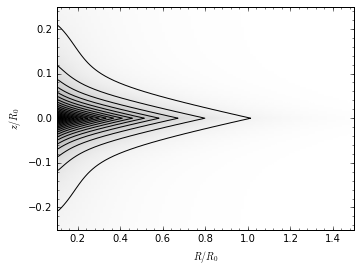

In [27]:
potential.plotDensities(
        pot,
        rmin=0.1,
        zmax=0.25, zmin=-0.25,
        nrs =101,  nzs =101
        )

### 4. How does the orbit belonging to the actions I just calculated looks like?

$\texttt{galpy}$ allows you to integrate and plot the orbit.

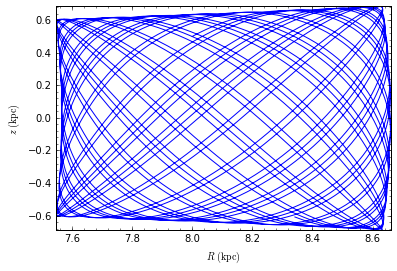

In [28]:
from galpy import orbit

#initialize orbit with coordinates of ii-th star:
ii = 0
o = orbit.Orbit(vxvv=[R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]],ro=_REFR0,vo=_REFV0)
#the unit scales are needed for plotting in physical units

#integrate orbit:
ts = np.linspace(0,100,10000)
o.integrate(ts,pot)

#plot orbit:
o.plot()

### 5. My stellar 6D coordinates have measurement uncertainties - how can I translate them to action space?

In [29]:
[TO DO]

SyntaxError: invalid syntax (<ipython-input-29-3fed51765aa6>, line 1)

### 6. I want to do other stuff - is it possible with $\texttt{galpy}$?

There is a lot of stuff you can do with $\texttt{galpy}$. Just have a look at Jo's very good documentation: http://galpy.readthedocs.io/en/latest/ 

Or just write an email to us, Wilma Trick (trick@mpia.de) and Johanna Coronado (coronado@mpia.de), or to Jo Bovy (bovy@astro.utoronto.ca).

### 7. This is great - but what *are* actions?

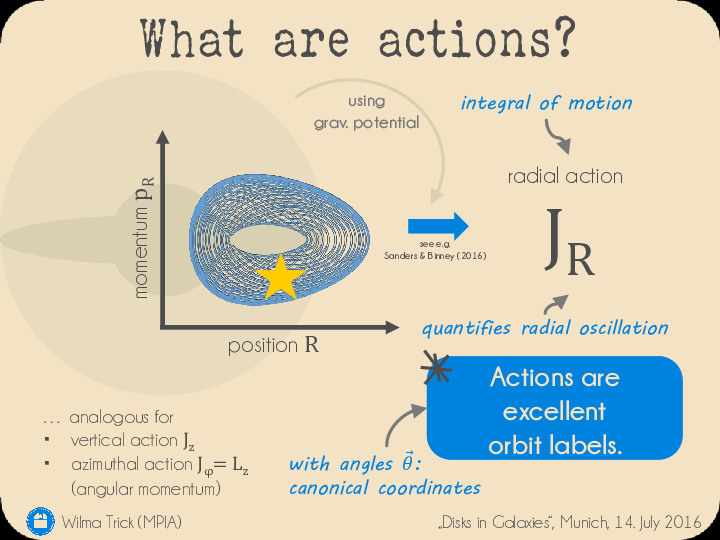

In [32]:
from wand.image import Image as WImage
img = WImage(filename='What_are_actions_slide.pdf')
img